In [1]:
import torchvision
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from skimage import io
import time
import ast 
from PIL import *
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# subset / old csv
# df = pd.read_csv('temp.csv')

# area larger than 1000
# df = pd.read_csv('area_larger_than_1000.csv')

# full dataset 
df = pd.read_csv('large_nodules_png_bounding_box.csv')

# subset of dataset (25%)
# _ , X_random, = train_test_split(df, test_size=0.25, random_state=0)
# X_random.to_csv('subset.csv',index=False)
# df = X_random

df

path   imageName  \
0     /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000059.png   
1     /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000008.png   
2     /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000109.png   
3     /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000063.png   
4     /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000005.png   
...                                                 ...         ...   
9395  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000017.png   
9396  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000082.png   
9397  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000133.png   
9398  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000051.png   
9399  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000113.png   

                                         SOPInstanceUID  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.319084926500...   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.749728215582...   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.327906493223...   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.230680133701...   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.212532866259...   
...                                                 ...   
9395  1.3.6.1.4.1.14519.5.2.1.6279.6001.323491922755...   
9396  1.3.6.1.4.1.14519.5.2.1.6279.6001.276843939440...   
9397  1.3.6.1.4.1.14519.5.2.1.6279.6001.207293484767...   
9398  1.3.6.1.4.1.14519.5.2.1.6279.6001.518873247105...   
9399  1.3.6.1.4.1.14519.5.2.1.6279.6001.195509175412...   

                               boxes  areas  
0     [[165.0, 140.0, 199.0, 161.0]]  714.0  
1     [[167.0, 134.0, 201.0, 160.0]]  884.0  
2     [[167.0, 134.0, 202.0, 161.0]]  945.0  
3     [[168.0, 135.0, 201.0, 160.0]]  825.0  
4     [[180.0, 133.0, 200.0, 154.0]]  420.0  
...                              ...    ...  
9395  [[373.0, 352.0, 384.0, 364.0]]  132.0  
9396  [[346.0, 350.0, 361.0, 361.0]]  165.0  
9397  [[345.0, 351.0, 358.0, 361.0]]  130.0  
9398  [[374.0, 354.0, 384.0, 362.0]]   80.0  
9399  [[344.0, 351.0, 357.0, 362.0]]  143.0  

[9400 rows x 5 columns]

In [5]:
# split dataset into 60, 20, 20 
train_data, test_data = train_test_split(df, test_size=0.40, random_state=2020)
valid_data, test_data = train_test_split(test_data, test_size=0.50, random_state=2020)
train_data.index = np.arange(len(train_data))
valid_data.index = np.arange(len(valid_data))
test_data.index = np.arange(len(test_data))

In [6]:
train_data.to_csv("large_nodules_train.csv", index=False)
valid_data.to_csv("large_nodules_valid.csv", index=False)
test_data.to_csv("large_nodules_test.csv", index=False)

In [7]:
from torchvision import transforms
# torchvision models are trained on input images normalized to [0 1] range .ToPILImage() function achives this
# additional normalization is required see: http://pytorch.org/docs/master/torchvision/models.html

train_transform = transforms.Compose([
        transforms.ToPILImage(),
#         transforms.RandomResizedCrop(512),
        transforms.CenterCrop(512),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
#         transforms.Normalize([0.29279277, 0.29279277, 0.29279277], [0.25384966, 0.25384966, 0.25384966])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(512),
        transforms.ToTensor()])
#         transforms.Normalize([0.29279277, 0.29279277, 0.29279277], [0.25384966, 0.25384966, 0.25384966])])

class Faster_RCNN_Dataloader(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        # get image path
        img_name = (self.data_frame.iloc[idx, 0])
        
#         # open image 
#         image = io.imread(img_name)
#         # 3 channels
#         image = np.array(image)
        image = cv2.imread(img_name) # Read image with cv2
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = (image - image.min())/(image.max() - image.min()) * 255.0
#         plt.imshow(image)
        
#         if len(image.shape) > 2 and image.shape[2] == 4:
#             image = image[:,:,0]       
#         image = np.repeat(image[None,...],3,axis=0)
        
        # transform image? 
#         plt.imshow(image)
        if self.transform:
            image = self.transform(np.uint8(image))
#         plt.imshow(image.squeeze().numpy())
    
        d = {}
        d['boxes'] = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))
        d['labels'] = torch.ones([1], dtype=torch.int64)
        
        return image, d

# change dataloader output to lists.
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    return list(xx), list(yy)

In [8]:
train_df_path = 'large_nodules_train.csv'
validate_df_path = 'large_nodules_valid.csv'
test_df_path = 'large_nodules_test.csv'

transformed_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=train_transform),
                       'validate':Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform),
                       'test':Faster_RCNN_Dataloader(test_df_path)}
bs = 8

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, collate_fn = pad_collate, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}


# one dataloader / phase, may be too memory intensive...

# train_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=train_transform)}
# validate_dataset = {'validate': Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform)}
# test_dataset = {'test': Faster_RCNN_Dataloader(test_df_path)}

# bs = 16 #if bigger, running out of memory in p100

# train_dataloader = {x : DataLoader(train_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['train']}
# validate_dataloader = {x : DataLoader(validate_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['validate']}
# test_dataloader = {x : DataLoader(test_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['test']}
# data_sizes ={len(dataset[x]) for x in ['train']}

In [9]:
mean_1 = []
mean_2 = []
mean_3 = []

std_1 = []
std_2 = []
std_3 = []

for i, data in enumerate(dataloader['train']):
    for i in data[0]:
        numpy_image = i.numpy()

        mean_1.append(np.mean(numpy_image[0,:,:]))
        mean_2.append(np.mean(numpy_image[1,:,:]))
        mean_3.append(np.mean(numpy_image[2,:,:]))
        
        std_1.append(np.std(numpy_image[0,:,:]))
        std_1.append(np.std(numpy_image[1,:,:]))
        std_3.append(np.std(numpy_image[2,:,:]))
        

pop_mean1 = np.array(mean_1).mean()
pop_mean2 = np.array(mean_2).mean()
pop_mean3 = np.array(mean_3).mean()

pop_std1 = np.array(std_1).mean()
pop_std2 = np.array(std_2).mean()
pop_std3 = np.array(std_3).mean()


KeyboardInterrupt: 

In [ ]:
pop_mean3

In [ ]:
pop_std

In [ ]:
# check if dataloader loaded correctly
# images1, targets1 = next(iter(train_dataloader['train']))
# images2, targets2 = next(iter(validate_dataloader['validate']))
# images3, targets3 = next(iter(test_dataloader['test']))

# to check dim of list dataloader
# len(images) = batch
# len(images[0]) = channel
# len(images[0]) = height
# len(images[0]) = width
images4, targets4 = next(iter(dataloader['train']))
len(images4[0])

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (nodule) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone = torchvision.models.vgg16(pretrained=True).features

# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280
backbone.out_channels = 512

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
anchor_generator = AnchorGenerator(sizes=((36, 40, 48, 49, 56, 64, 72),),
                                  aspect_ratios=((1.0, 1.25, 1.5),))


# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)

# # tried to run not pretrained.
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=2).to(device)

# for multiple nodes
torch.nn.DataParallel(model)


optimizer = torch.optim.SGD(model.parameters(), lr=1e-7,
                                momentum=0.9, weight_decay=1e-5)


lambda_func = lambda epoch: 0.5 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

# unused 
cel = nn.MSELoss() 

In [17]:
# move dict/lists to gpu 
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [18]:
classes = ['__background__', 'nodule']

In [19]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(float(boxA[0]), float(boxB[0]))
    yA = max(float(boxA[1]), float(boxB[1]))
    xB = min(float(boxA[2]), float(boxB[2]))
    yB = min(float(boxA[3]), float(boxB[3]))
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [20]:
def train_model(model, dataloader,optimizer, scheduler, loss_fn, num_epochs = 10, verbose = True):
    acc_dict = {'train':[]}
    loss_dict = {'train':[], 'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    epochLossTrain = list()
#     epochAccTrain = list()
    epochLossValidate = list()
    epochAccValidate = list()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        losslist = []
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()   
            num = 0 # calculate which batch --> enumerate not working
            loss = 0.0
            for image, target in dataloader[p]:
                optimizer.zero_grad()
                # move data to gpu
#                 plt.imshow(image[0].squeeze().numpy())
                image = move_to(image,device)
                target = move_to(target,device)
                if (num % 10 == 0):
                    print('{} set | epoch: {:3d} | {:6d}/{:6d} batches'.format(p, i, num + 1, len(dataloader[p])))
                num = num + 1
                
                if p == 'train':
                    # loss = sum of all 4 losses returned
                    output = model((image), target)
                    loss = sum(loss for loss in output.values())
                if p == 'validate':
                    # helps with memory 
                    with torch.no_grad():
                        model.eval()  
                        output = model((image))
                        pred_score = [] # confidence score
                        pred_boxes = [] # bounding box
                        pred_class = [] # predicted class
                        maxIOUs = []
                        maxScores = []
                        # loop through output (len(output) = batch size )
                        for j, out in enumerate(output):
                            # documentation: ['boxes'] = [x1, y1, x2, y2]
                            pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
                            pred_score = list(out['scores'].cpu().detach().numpy())
                            pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]
                            
                            # get correct label
                            # documentation: # 0 xmin, 1 ymin, 2 xmax, 3 ymax
                            t = target[j]['boxes'].cpu().detach().numpy()[0]
                            
                            # want to input: x min , y max, x max, y min
#                             target_box =  [t[0],t[3],t[2],t[1]]

                            target_box =  [t[0],t[1],t[2],t[3]]
                            
                            # get index of max score - in theory want this one.
#                             index = pred_score.index(min(pred_score))
                
                            
                            # right now, get iou of every predicted box
                            # and keep max iou 
                            iou = []
#                             iou.append(bb_intersection_over_union(target_box, pred_boxes[index]))
                            for ind in pred_boxes:
                                iou.append(bb_intersection_over_union(target_box, ind))
                            maxIOUs.append(max(iou))    
                            
                        # sum max iou for each validate run to print out to see if above 0.0
                        epoch_acc = (sum(maxIOUs)/len(maxIOUs))

                # printing average loss / epoch
                num_imgs = len(image)
                running_loss += loss*num_imgs
                running_total += num_imgs
                
                if p == 'train':
                    loss.backward()
                    optimizer.step()
                    
            epoch_loss = float(running_loss/running_total)
            
            # keep epoch loss / accuracy (for validation)
            if p == 'train':
                epochLossTrain.append(epoch_loss)
#                 epochAccTrain.append(epoch_acc)
            if p == 'validate':
                epochLossValidate.append(epoch_loss)
                epochAccValidate.append(epoch_acc)
            if verbose or (i%10 == 0):
                if p == 'train':
                    print('Phase:{}, epoch loss: {:.4f}'.format(p, epoch_loss))
                if p == 'validate':
                    print('Phase:{}, epoch loss: {:.4f} | epoch accuracy: {:.4f}'.format(p, epoch_loss, epoch_acc))
                    
            # old code
#             acc_dict[p].append(epoch_acc)
#             loss_dict[p].append(epoch_loss)      
#             if p == 'validate':
#                 if epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     best_model_wts = model.state_dict()
#             else:
            # schedule supposed to be under "else:" - not sure what it does...
            if scheduler:
                scheduler.step()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val acc: {:4f}'.format(best_acc))
    
#     model.load_state_dict(best_model_wts)
#     return model, acc_dict, loss_dict, epochLossTrain, epochLossValidate, epochAccTrain, epochAccValidate
    return model, acc_dict, loss_dict, epochLossTrain ,epochLossValidate, epochAccValidate


In [21]:
model, acc_dict, loss_dict, epochLossTrain,epochLossValidate,epochAccValidate = train_model(model, dataloader, optimizer, 
                                                                        scheduler, 
                                                                        cel, 
                                                                        num_epochs=100)


Epoch: 0/99
----------
train set | epoch:   0 |      1/   705 batches


/home/njm363/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


train set | epoch:   0 |     11/   705 batches
train set | epoch:   0 |     21/   705 batches
train set | epoch:   0 |     31/   705 batches
train set | epoch:   0 |     41/   705 batches
train set | epoch:   0 |     51/   705 batches
train set | epoch:   0 |     61/   705 batches
train set | epoch:   0 |     71/   705 batches
train set | epoch:   0 |     81/   705 batches
train set | epoch:   0 |     91/   705 batches
train set | epoch:   0 |    101/   705 batches
train set | epoch:   0 |    111/   705 batches
train set | epoch:   0 |    121/   705 batches
train set | epoch:   0 |    131/   705 batches
train set | epoch:   0 |    141/   705 batches
train set | epoch:   0 |    151/   705 batches
train set | epoch:   0 |    161/   705 batches
train set | epoch:   0 |    171/   705 batches
train set | epoch:   0 |    181/   705 batches
train set | epoch:   0 |    191/   705 batches
train set | epoch:   0 |    201/   705 batches
train set | epoch:   0 |    211/   705 batches
train set | e

validate set | epoch:   1 |     51/   235 batches
validate set | epoch:   1 |     61/   235 batches
validate set | epoch:   1 |     71/   235 batches
validate set | epoch:   1 |     81/   235 batches
validate set | epoch:   1 |     91/   235 batches
validate set | epoch:   1 |    101/   235 batches
validate set | epoch:   1 |    111/   235 batches
validate set | epoch:   1 |    121/   235 batches
validate set | epoch:   1 |    131/   235 batches
validate set | epoch:   1 |    141/   235 batches
validate set | epoch:   1 |    151/   235 batches
validate set | epoch:   1 |    161/   235 batches
validate set | epoch:   1 |    171/   235 batches
validate set | epoch:   1 |    181/   235 batches
validate set | epoch:   1 |    191/   235 batches
validate set | epoch:   1 |    201/   235 batches
validate set | epoch:   1 |    211/   235 batches
validate set | epoch:   1 |    221/   235 batches
validate set | epoch:   1 |    231/   235 batches
Phase:validate, epoch loss: 0.0000 | epoch accurac

train set | epoch:   3 |    541/   705 batches
train set | epoch:   3 |    551/   705 batches
train set | epoch:   3 |    561/   705 batches
train set | epoch:   3 |    571/   705 batches
train set | epoch:   3 |    581/   705 batches
train set | epoch:   3 |    591/   705 batches
train set | epoch:   3 |    601/   705 batches
train set | epoch:   3 |    611/   705 batches
train set | epoch:   3 |    621/   705 batches
train set | epoch:   3 |    631/   705 batches
train set | epoch:   3 |    641/   705 batches
train set | epoch:   3 |    651/   705 batches
train set | epoch:   3 |    661/   705 batches
train set | epoch:   3 |    671/   705 batches
train set | epoch:   3 |    681/   705 batches
train set | epoch:   3 |    691/   705 batches
train set | epoch:   3 |    701/   705 batches
Phase:train, epoch loss: 1.4173
validate set | epoch:   3 |      1/   235 batches
validate set | epoch:   3 |     11/   235 batches
validate set | epoch:   3 |     21/   235 batches
validate set | epoc

train set | epoch:   5 |    311/   705 batches
train set | epoch:   5 |    321/   705 batches
train set | epoch:   5 |    331/   705 batches
train set | epoch:   5 |    341/   705 batches
train set | epoch:   5 |    351/   705 batches
train set | epoch:   5 |    361/   705 batches
train set | epoch:   5 |    371/   705 batches
train set | epoch:   5 |    381/   705 batches
train set | epoch:   5 |    391/   705 batches
train set | epoch:   5 |    401/   705 batches
train set | epoch:   5 |    411/   705 batches
train set | epoch:   5 |    421/   705 batches
train set | epoch:   5 |    431/   705 batches
train set | epoch:   5 |    441/   705 batches
train set | epoch:   5 |    451/   705 batches
train set | epoch:   5 |    461/   705 batches
train set | epoch:   5 |    471/   705 batches
train set | epoch:   5 |    481/   705 batches
train set | epoch:   5 |    491/   705 batches
train set | epoch:   5 |    501/   705 batches
train set | epoch:   5 |    511/   705 batches
train set | e

train set | epoch:   7 |     81/   705 batches
train set | epoch:   7 |     91/   705 batches
train set | epoch:   7 |    101/   705 batches
train set | epoch:   7 |    111/   705 batches
train set | epoch:   7 |    121/   705 batches
train set | epoch:   7 |    131/   705 batches
train set | epoch:   7 |    141/   705 batches
train set | epoch:   7 |    151/   705 batches
train set | epoch:   7 |    161/   705 batches
train set | epoch:   7 |    171/   705 batches
train set | epoch:   7 |    181/   705 batches
train set | epoch:   7 |    191/   705 batches
train set | epoch:   7 |    201/   705 batches
train set | epoch:   7 |    211/   705 batches
train set | epoch:   7 |    221/   705 batches
train set | epoch:   7 |    231/   705 batches
train set | epoch:   7 |    241/   705 batches
train set | epoch:   7 |    251/   705 batches
train set | epoch:   7 |    261/   705 batches
train set | epoch:   7 |    271/   705 batches
train set | epoch:   7 |    281/   705 batches
train set | e

validate set | epoch:   8 |    111/   235 batches
validate set | epoch:   8 |    121/   235 batches
validate set | epoch:   8 |    131/   235 batches
validate set | epoch:   8 |    141/   235 batches
validate set | epoch:   8 |    151/   235 batches
validate set | epoch:   8 |    161/   235 batches
validate set | epoch:   8 |    171/   235 batches
validate set | epoch:   8 |    181/   235 batches
validate set | epoch:   8 |    191/   235 batches
validate set | epoch:   8 |    201/   235 batches
validate set | epoch:   8 |    211/   235 batches
validate set | epoch:   8 |    221/   235 batches
validate set | epoch:   8 |    231/   235 batches
Phase:validate, epoch loss: 0.0000 | epoch accuracy: 0.1097
Epoch: 9/99
----------
train set | epoch:   9 |      1/   705 batches
train set | epoch:   9 |     11/   705 batches
train set | epoch:   9 |     21/   705 batches
train set | epoch:   9 |     31/   705 batches
train set | epoch:   9 |     41/   705 batches
train set | epoch:   9 |     51/

train set | epoch:  10 |    601/   705 batches
train set | epoch:  10 |    611/   705 batches
train set | epoch:  10 |    621/   705 batches
train set | epoch:  10 |    631/   705 batches
train set | epoch:  10 |    641/   705 batches
train set | epoch:  10 |    651/   705 batches
train set | epoch:  10 |    661/   705 batches
train set | epoch:  10 |    671/   705 batches
train set | epoch:  10 |    681/   705 batches
train set | epoch:  10 |    691/   705 batches
train set | epoch:  10 |    701/   705 batches
Phase:train, epoch loss: 1.4173
validate set | epoch:  10 |      1/   235 batches
validate set | epoch:  10 |     11/   235 batches
validate set | epoch:  10 |     21/   235 batches
validate set | epoch:  10 |     31/   235 batches
validate set | epoch:  10 |     41/   235 batches
validate set | epoch:  10 |     51/   235 batches
validate set | epoch:  10 |     61/   235 batches
validate set | epoch:  10 |     71/   235 batches
validate set | epoch:  10 |     81/   235 batches
v

train set | epoch:  12 |    371/   705 batches
train set | epoch:  12 |    381/   705 batches
train set | epoch:  12 |    391/   705 batches
train set | epoch:  12 |    401/   705 batches
train set | epoch:  12 |    411/   705 batches
train set | epoch:  12 |    421/   705 batches
train set | epoch:  12 |    431/   705 batches
train set | epoch:  12 |    441/   705 batches
train set | epoch:  12 |    451/   705 batches
train set | epoch:  12 |    461/   705 batches
train set | epoch:  12 |    471/   705 batches
train set | epoch:  12 |    481/   705 batches
train set | epoch:  12 |    491/   705 batches
train set | epoch:  12 |    501/   705 batches
train set | epoch:  12 |    511/   705 batches
train set | epoch:  12 |    521/   705 batches
train set | epoch:  12 |    531/   705 batches
train set | epoch:  12 |    541/   705 batches
train set | epoch:  12 |    551/   705 batches
train set | epoch:  12 |    561/   705 batches
train set | epoch:  12 |    571/   705 batches
train set | e

train set | epoch:  14 |    141/   705 batches
train set | epoch:  14 |    151/   705 batches
train set | epoch:  14 |    161/   705 batches
train set | epoch:  14 |    171/   705 batches
train set | epoch:  14 |    181/   705 batches
train set | epoch:  14 |    191/   705 batches
train set | epoch:  14 |    201/   705 batches
train set | epoch:  14 |    211/   705 batches
train set | epoch:  14 |    221/   705 batches
train set | epoch:  14 |    231/   705 batches
train set | epoch:  14 |    241/   705 batches
train set | epoch:  14 |    251/   705 batches
train set | epoch:  14 |    261/   705 batches
train set | epoch:  14 |    271/   705 batches
train set | epoch:  14 |    281/   705 batches
train set | epoch:  14 |    291/   705 batches
train set | epoch:  14 |    301/   705 batches
train set | epoch:  14 |    311/   705 batches
train set | epoch:  14 |    321/   705 batches
train set | epoch:  14 |    331/   705 batches
train set | epoch:  14 |    341/   705 batches
train set | e

validate set | epoch:  15 |    171/   235 batches
validate set | epoch:  15 |    181/   235 batches
validate set | epoch:  15 |    191/   235 batches
validate set | epoch:  15 |    201/   235 batches
validate set | epoch:  15 |    211/   235 batches
validate set | epoch:  15 |    221/   235 batches
validate set | epoch:  15 |    231/   235 batches
Phase:validate, epoch loss: 0.0000 | epoch accuracy: 0.0631
Epoch: 16/99
----------
train set | epoch:  16 |      1/   705 batches
train set | epoch:  16 |     11/   705 batches
train set | epoch:  16 |     21/   705 batches
train set | epoch:  16 |     31/   705 batches
train set | epoch:  16 |     41/   705 batches
train set | epoch:  16 |     51/   705 batches
train set | epoch:  16 |     61/   705 batches
train set | epoch:  16 |     71/   705 batches
train set | epoch:  16 |     81/   705 batches
train set | epoch:  16 |     91/   705 batches
train set | epoch:  16 |    101/   705 batches
train set | epoch:  16 |    111/   705 batches
tr

train set | epoch:  17 |    671/   705 batches
train set | epoch:  17 |    681/   705 batches
train set | epoch:  17 |    691/   705 batches
train set | epoch:  17 |    701/   705 batches
Phase:train, epoch loss: 1.4173
validate set | epoch:  17 |      1/   235 batches
validate set | epoch:  17 |     11/   235 batches
validate set | epoch:  17 |     21/   235 batches
validate set | epoch:  17 |     31/   235 batches
validate set | epoch:  17 |     41/   235 batches
validate set | epoch:  17 |     51/   235 batches
validate set | epoch:  17 |     61/   235 batches
validate set | epoch:  17 |     71/   235 batches
validate set | epoch:  17 |     81/   235 batches
validate set | epoch:  17 |     91/   235 batches
validate set | epoch:  17 |    101/   235 batches
validate set | epoch:  17 |    111/   235 batches
validate set | epoch:  17 |    121/   235 batches
validate set | epoch:  17 |    131/   235 batches
validate set | epoch:  17 |    141/   235 batches
validate set | epoch:  17 |   

train set | epoch:  19 |    441/   705 batches
train set | epoch:  19 |    451/   705 batches
train set | epoch:  19 |    461/   705 batches
train set | epoch:  19 |    471/   705 batches
train set | epoch:  19 |    481/   705 batches
train set | epoch:  19 |    491/   705 batches
train set | epoch:  19 |    501/   705 batches
train set | epoch:  19 |    511/   705 batches
train set | epoch:  19 |    521/   705 batches
train set | epoch:  19 |    531/   705 batches
train set | epoch:  19 |    541/   705 batches
train set | epoch:  19 |    551/   705 batches
train set | epoch:  19 |    561/   705 batches
train set | epoch:  19 |    571/   705 batches
train set | epoch:  19 |    581/   705 batches
train set | epoch:  19 |    591/   705 batches
train set | epoch:  19 |    601/   705 batches
train set | epoch:  19 |    611/   705 batches
train set | epoch:  19 |    621/   705 batches
train set | epoch:  19 |    631/   705 batches
train set | epoch:  19 |    641/   705 batches
train set | e

train set | epoch:  21 |    211/   705 batches
train set | epoch:  21 |    221/   705 batches
train set | epoch:  21 |    231/   705 batches
train set | epoch:  21 |    241/   705 batches
train set | epoch:  21 |    251/   705 batches
train set | epoch:  21 |    261/   705 batches
train set | epoch:  21 |    271/   705 batches
train set | epoch:  21 |    281/   705 batches
train set | epoch:  21 |    291/   705 batches
train set | epoch:  21 |    301/   705 batches
train set | epoch:  21 |    311/   705 batches
train set | epoch:  21 |    321/   705 batches
train set | epoch:  21 |    331/   705 batches
train set | epoch:  21 |    341/   705 batches
train set | epoch:  21 |    351/   705 batches
train set | epoch:  21 |    361/   705 batches
train set | epoch:  21 |    371/   705 batches
train set | epoch:  21 |    381/   705 batches
train set | epoch:  21 |    391/   705 batches
train set | epoch:  21 |    401/   705 batches
train set | epoch:  21 |    411/   705 batches
train set | e

Phase:validate, epoch loss: 0.0000 | epoch accuracy: 0.0791
Epoch: 23/99
----------
train set | epoch:  23 |      1/   705 batches
train set | epoch:  23 |     11/   705 batches
train set | epoch:  23 |     21/   705 batches
train set | epoch:  23 |     31/   705 batches
train set | epoch:  23 |     41/   705 batches
train set | epoch:  23 |     51/   705 batches
train set | epoch:  23 |     61/   705 batches
train set | epoch:  23 |     71/   705 batches
train set | epoch:  23 |     81/   705 batches
train set | epoch:  23 |     91/   705 batches
train set | epoch:  23 |    101/   705 batches
train set | epoch:  23 |    111/   705 batches
train set | epoch:  23 |    121/   705 batches
train set | epoch:  23 |    131/   705 batches
train set | epoch:  23 |    141/   705 batches
train set | epoch:  23 |    151/   705 batches
train set | epoch:  23 |    161/   705 batches
train set | epoch:  23 |    171/   705 batches
train set | epoch:  23 |    181/   705 batches
train set | epoch:  23 

validate set | epoch:  24 |     21/   235 batches
validate set | epoch:  24 |     31/   235 batches
validate set | epoch:  24 |     41/   235 batches
validate set | epoch:  24 |     51/   235 batches
validate set | epoch:  24 |     61/   235 batches
validate set | epoch:  24 |     71/   235 batches
validate set | epoch:  24 |     81/   235 batches
validate set | epoch:  24 |     91/   235 batches
validate set | epoch:  24 |    101/   235 batches
validate set | epoch:  24 |    111/   235 batches
validate set | epoch:  24 |    121/   235 batches
validate set | epoch:  24 |    131/   235 batches
validate set | epoch:  24 |    141/   235 batches
validate set | epoch:  24 |    151/   235 batches
validate set | epoch:  24 |    161/   235 batches
validate set | epoch:  24 |    171/   235 batches
validate set | epoch:  24 |    181/   235 batches
validate set | epoch:  24 |    191/   235 batches
validate set | epoch:  24 |    201/   235 batches
validate set | epoch:  24 |    211/   235 batches


train set | epoch:  26 |    511/   705 batches
train set | epoch:  26 |    521/   705 batches
train set | epoch:  26 |    531/   705 batches
train set | epoch:  26 |    541/   705 batches
train set | epoch:  26 |    551/   705 batches
train set | epoch:  26 |    561/   705 batches
train set | epoch:  26 |    571/   705 batches
train set | epoch:  26 |    581/   705 batches
train set | epoch:  26 |    591/   705 batches
train set | epoch:  26 |    601/   705 batches
train set | epoch:  26 |    611/   705 batches
train set | epoch:  26 |    621/   705 batches
train set | epoch:  26 |    631/   705 batches
train set | epoch:  26 |    641/   705 batches
train set | epoch:  26 |    651/   705 batches
train set | epoch:  26 |    661/   705 batches
train set | epoch:  26 |    671/   705 batches
train set | epoch:  26 |    681/   705 batches
train set | epoch:  26 |    691/   705 batches
train set | epoch:  26 |    701/   705 batches
Phase:train, epoch loss: 1.4173
validate set | epoch:  26 | 

train set | epoch:  28 |    281/   705 batches
train set | epoch:  28 |    291/   705 batches
train set | epoch:  28 |    301/   705 batches
train set | epoch:  28 |    311/   705 batches
train set | epoch:  28 |    321/   705 batches
train set | epoch:  28 |    331/   705 batches
train set | epoch:  28 |    341/   705 batches
train set | epoch:  28 |    351/   705 batches
train set | epoch:  28 |    361/   705 batches
train set | epoch:  28 |    371/   705 batches
train set | epoch:  28 |    381/   705 batches
train set | epoch:  28 |    391/   705 batches
train set | epoch:  28 |    401/   705 batches
train set | epoch:  28 |    411/   705 batches
train set | epoch:  28 |    421/   705 batches
train set | epoch:  28 |    431/   705 batches
train set | epoch:  28 |    441/   705 batches
train set | epoch:  28 |    451/   705 batches
train set | epoch:  28 |    461/   705 batches
train set | epoch:  28 |    471/   705 batches
train set | epoch:  28 |    481/   705 batches
train set | e

train set | epoch:  30 |     51/   705 batches
train set | epoch:  30 |     61/   705 batches
train set | epoch:  30 |     71/   705 batches
train set | epoch:  30 |     81/   705 batches
train set | epoch:  30 |     91/   705 batches
train set | epoch:  30 |    101/   705 batches
train set | epoch:  30 |    111/   705 batches
train set | epoch:  30 |    121/   705 batches
train set | epoch:  30 |    131/   705 batches
train set | epoch:  30 |    141/   705 batches
train set | epoch:  30 |    151/   705 batches
train set | epoch:  30 |    161/   705 batches
train set | epoch:  30 |    171/   705 batches
train set | epoch:  30 |    181/   705 batches
train set | epoch:  30 |    191/   705 batches
train set | epoch:  30 |    201/   705 batches
train set | epoch:  30 |    211/   705 batches
train set | epoch:  30 |    221/   705 batches
train set | epoch:  30 |    231/   705 batches
train set | epoch:  30 |    241/   705 batches
train set | epoch:  30 |    251/   705 batches
train set | e

validate set | epoch:  31 |     91/   235 batches
validate set | epoch:  31 |    101/   235 batches
validate set | epoch:  31 |    111/   235 batches
validate set | epoch:  31 |    121/   235 batches
validate set | epoch:  31 |    131/   235 batches
validate set | epoch:  31 |    141/   235 batches
validate set | epoch:  31 |    151/   235 batches
validate set | epoch:  31 |    161/   235 batches
validate set | epoch:  31 |    171/   235 batches
validate set | epoch:  31 |    181/   235 batches
validate set | epoch:  31 |    191/   235 batches
validate set | epoch:  31 |    201/   235 batches
validate set | epoch:  31 |    211/   235 batches
validate set | epoch:  31 |    221/   235 batches
validate set | epoch:  31 |    231/   235 batches
Phase:validate, epoch loss: 0.0000 | epoch accuracy: 0.0683
Epoch: 32/99
----------
train set | epoch:  32 |      1/   705 batches
train set | epoch:  32 |     11/   705 batches
train set | epoch:  32 |     21/   705 batches
train set | epoch:  32 | 

train set | epoch:  33 |    581/   705 batches
train set | epoch:  33 |    591/   705 batches
train set | epoch:  33 |    601/   705 batches
train set | epoch:  33 |    611/   705 batches
train set | epoch:  33 |    621/   705 batches
train set | epoch:  33 |    631/   705 batches
train set | epoch:  33 |    641/   705 batches
train set | epoch:  33 |    651/   705 batches
train set | epoch:  33 |    661/   705 batches
train set | epoch:  33 |    671/   705 batches
train set | epoch:  33 |    681/   705 batches
train set | epoch:  33 |    691/   705 batches
train set | epoch:  33 |    701/   705 batches
Phase:train, epoch loss: 1.4173
validate set | epoch:  33 |      1/   235 batches
validate set | epoch:  33 |     11/   235 batches
validate set | epoch:  33 |     21/   235 batches
validate set | epoch:  33 |     31/   235 batches
validate set | epoch:  33 |     41/   235 batches
validate set | epoch:  33 |     51/   235 batches
validate set | epoch:  33 |     61/   235 batches
validat

train set | epoch:  35 |    351/   705 batches
train set | epoch:  35 |    361/   705 batches
train set | epoch:  35 |    371/   705 batches
train set | epoch:  35 |    381/   705 batches
train set | epoch:  35 |    391/   705 batches
train set | epoch:  35 |    401/   705 batches
train set | epoch:  35 |    411/   705 batches
train set | epoch:  35 |    421/   705 batches
train set | epoch:  35 |    431/   705 batches
train set | epoch:  35 |    441/   705 batches
train set | epoch:  35 |    451/   705 batches
train set | epoch:  35 |    461/   705 batches
train set | epoch:  35 |    471/   705 batches
train set | epoch:  35 |    481/   705 batches
train set | epoch:  35 |    491/   705 batches
train set | epoch:  35 |    501/   705 batches
train set | epoch:  35 |    511/   705 batches
train set | epoch:  35 |    521/   705 batches
train set | epoch:  35 |    531/   705 batches
train set | epoch:  35 |    541/   705 batches
train set | epoch:  35 |    551/   705 batches
train set | e

train set | epoch:  37 |    121/   705 batches
train set | epoch:  37 |    131/   705 batches
train set | epoch:  37 |    141/   705 batches
train set | epoch:  37 |    151/   705 batches
train set | epoch:  37 |    161/   705 batches
train set | epoch:  37 |    171/   705 batches
train set | epoch:  37 |    181/   705 batches
train set | epoch:  37 |    191/   705 batches
train set | epoch:  37 |    201/   705 batches
train set | epoch:  37 |    211/   705 batches
train set | epoch:  37 |    221/   705 batches
train set | epoch:  37 |    231/   705 batches
train set | epoch:  37 |    241/   705 batches
train set | epoch:  37 |    251/   705 batches
train set | epoch:  37 |    261/   705 batches
train set | epoch:  37 |    271/   705 batches
train set | epoch:  37 |    281/   705 batches
train set | epoch:  37 |    291/   705 batches
train set | epoch:  37 |    301/   705 batches
train set | epoch:  37 |    311/   705 batches
train set | epoch:  37 |    321/   705 batches
train set | e

validate set | epoch:  38 |    151/   235 batches
validate set | epoch:  38 |    161/   235 batches
validate set | epoch:  38 |    171/   235 batches
validate set | epoch:  38 |    181/   235 batches
validate set | epoch:  38 |    191/   235 batches
validate set | epoch:  38 |    201/   235 batches
validate set | epoch:  38 |    211/   235 batches
validate set | epoch:  38 |    221/   235 batches
validate set | epoch:  38 |    231/   235 batches
Phase:validate, epoch loss: 0.0000 | epoch accuracy: 0.1414
Epoch: 39/99
----------
train set | epoch:  39 |      1/   705 batches
train set | epoch:  39 |     11/   705 batches
train set | epoch:  39 |     21/   705 batches


KeyboardInterrupt: 

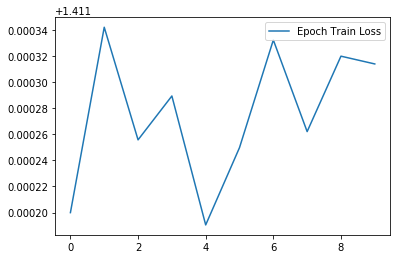

In [20]:
plt.plot(epochLossTrain, label = "Epoch Train Loss")
# plt.plot(epochLossValidate, label = "Epoch Validate Loss")
plt.legend(loc = "upper right")

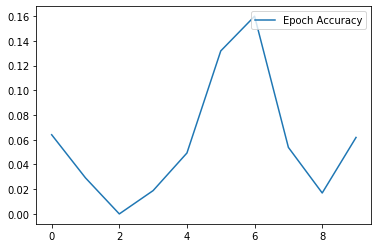

In [21]:
# plt.plot(epochLossTrain, label = "Epoch Train Loss")
plt.plot(epochAccValidate, label = "Epoch Accuracy")
plt.legend(loc = "upper right")

In [18]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    img = img.float()
    #     print(img)
    model.eval()
    img = move_to(img,device)
    pred = model([img]) # Pass the image to the model
#     print(pred_class)
    pred_class = [classes[i] for i in list(pred[0]['labels'].cpu().numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].cpu().detach().numpy()) 
#     print(pred_class)
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class, pred_t

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    
#     for i in range(len(boxes)):
#         print(boxes)
#         cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
#         cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
#     plt.figure(figsize=(5,5)) # display the output image
#     plt.imshow(img)
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
    return boxes
    
path = "/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000003.png"

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/home/njm363/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_

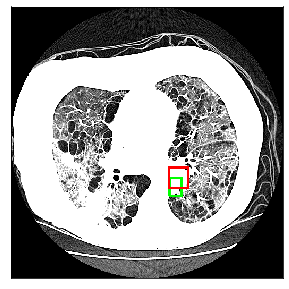

prediction box area:  775.9914 box area:  1404
0.2515254029808228


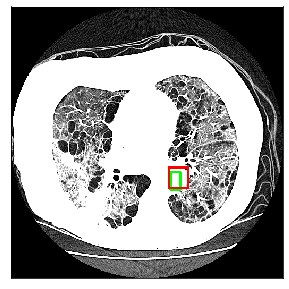

prediction box area:  627.46216 box area:  1404
0.38121731978019124


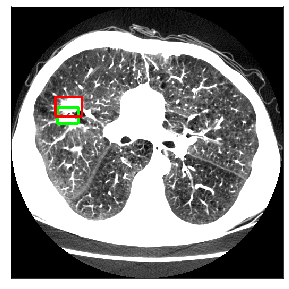

prediction box area:  1262.4454 box area:  1800
0.29300336426974993


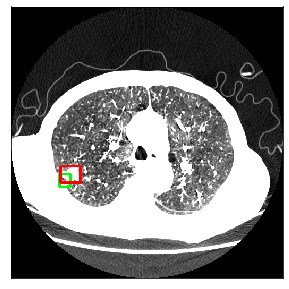

prediction box area:  486.45065 box area:  1147
0.2367111398188624


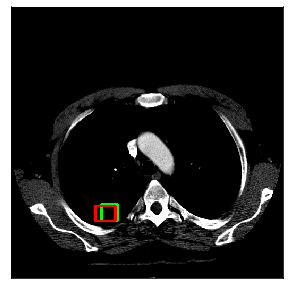

prediction box area:  983.25397 box area:  1064
0.5526359634645902


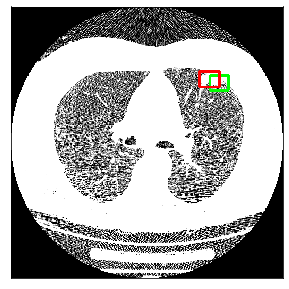

prediction box area:  972.1004 box area:  1102
0.22920443157375775


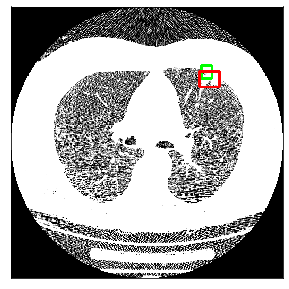

prediction box area:  487.10907 box area:  1102
0.21991944046679612


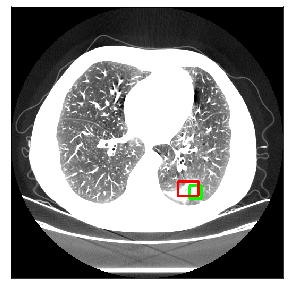

prediction box area:  544.736 box area:  1026
0.23869915151232407


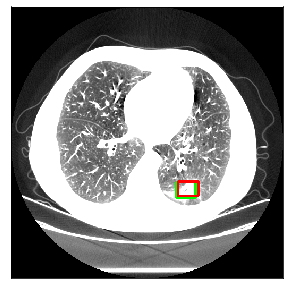

prediction box area:  1076.2704 box area:  1026
0.6701544769392742


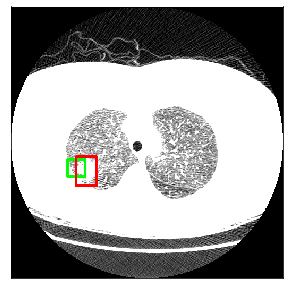

prediction box area:  1066.8346 box area:  2145
0.2278112891261324


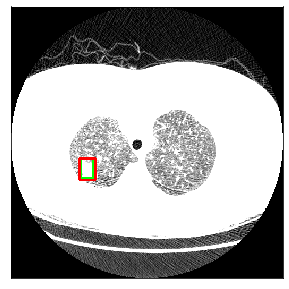

prediction box area:  904.2619 box area:  1189
0.7670138278078021


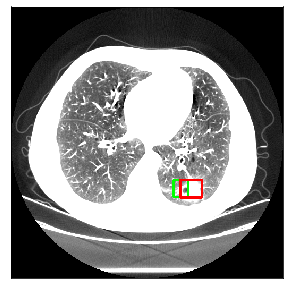

prediction box area:  856.43317 box area:  1353
0.3041846153730237


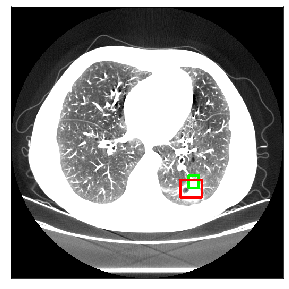

prediction box area:  458.56848 box area:  1353
0.21160014113860526


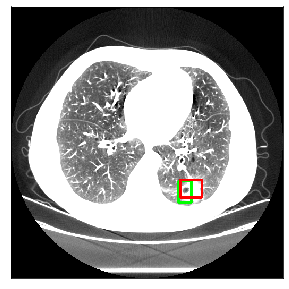

prediction box area:  952.3653 box area:  1353
0.40149834208182655


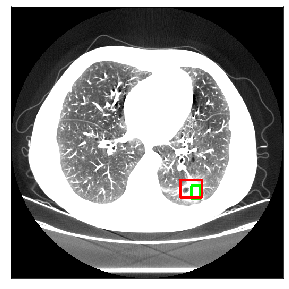

prediction box area:  457.40292 box area:  1353
0.2846255362583214


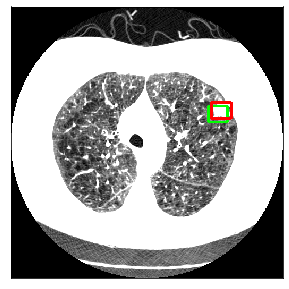

prediction box area:  1103.5077 box area:  1110
0.45950794753521235


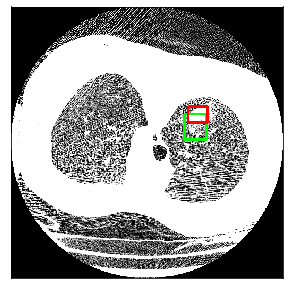

prediction box area:  2011.0116 box area:  1080
0.22245495549484914


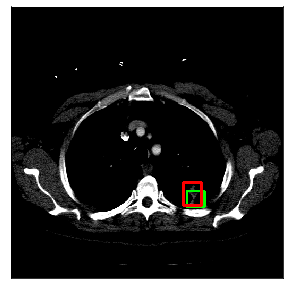

prediction box area:  991.4711 box area:  1462
0.4108585759715988


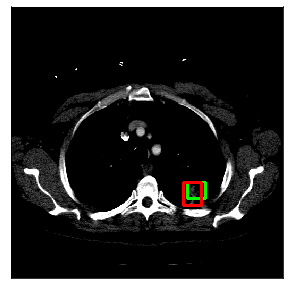

prediction box area:  1026.5265 box area:  1462
0.4684489504815138


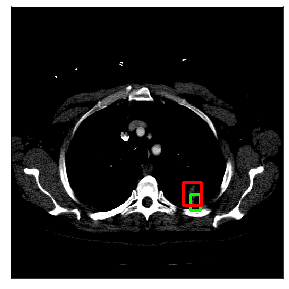

prediction box area:  543.977 box area:  1462
0.2406343351602148


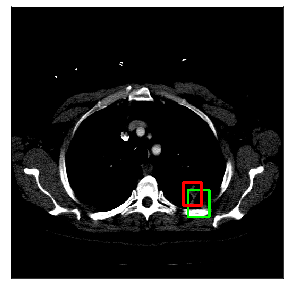

prediction box area:  2054.198 box area:  1462
0.25474913124976806


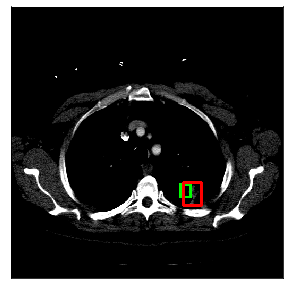

prediction box area:  479.45245 box area:  1462
0.2361599067870817


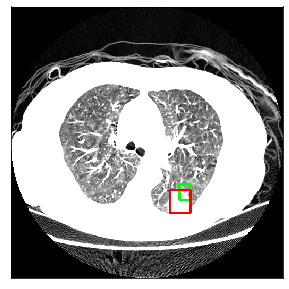

prediction box area:  579.2435 box area:  1634
0.21212716493181438


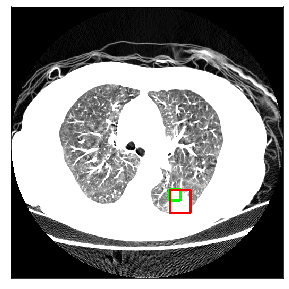

prediction box area:  424.36203 box area:  1634
0.2482038449744191


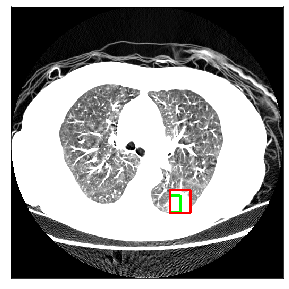

prediction box area:  584.55005 box area:  1634
0.37027149621586125


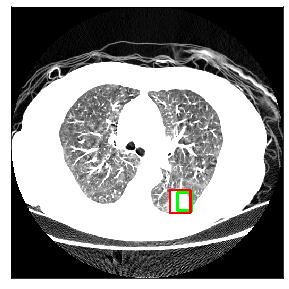

prediction box area:  930.42456 box area:  1634
0.47573428616205143


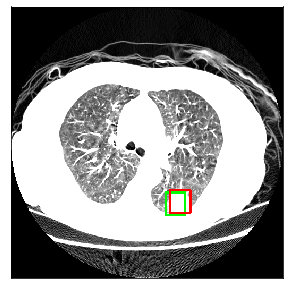

prediction box area:  1541.4786 box area:  1634
0.530378403614578


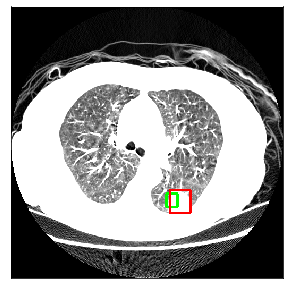

prediction box area:  538.3003 box area:  1634
0.21574891130142082


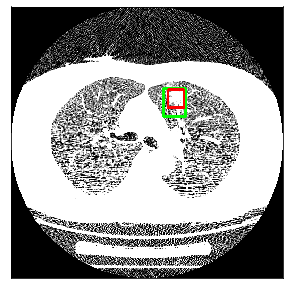

prediction box area:  2164.2234 box area:  1020
0.4802926320254949


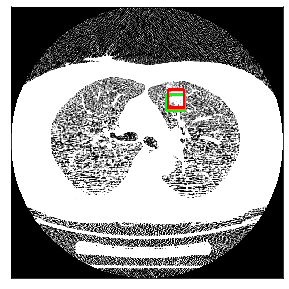

prediction box area:  1054.1783 box area:  1020
0.5440114418552113


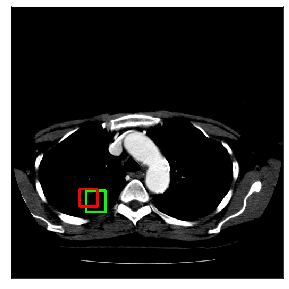

prediction box area:  1462.836 box area:  1089
0.3091470519192455


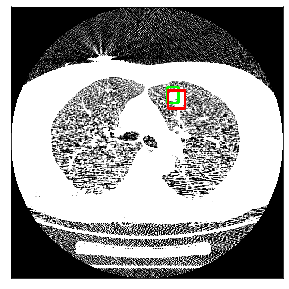

prediction box area:  598.22516 box area:  1088
0.41583388832875073


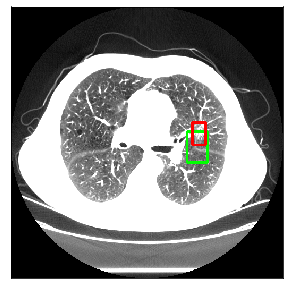

prediction box area:  2167.4036 box area:  1050
0.23878735614743216


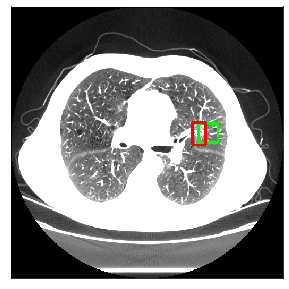

prediction box area:  1268.6412 box area:  1050
0.2518911952324214


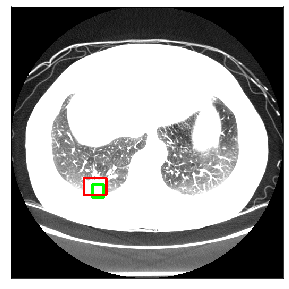

prediction box area:  513.30054 box area:  1344
0.2800758399030653


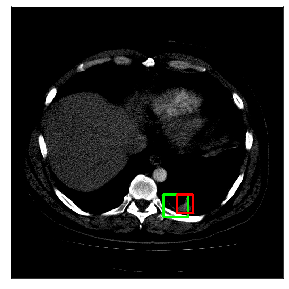

prediction box area:  1992.5764 box area:  1050
0.34560934590995884


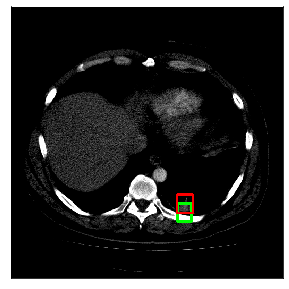

prediction box area:  879.7559 box area:  1050
0.32636441582585624


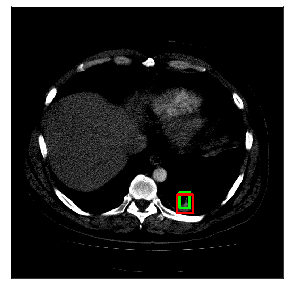

prediction box area:  553.8106 box area:  1050
0.4601569912456921


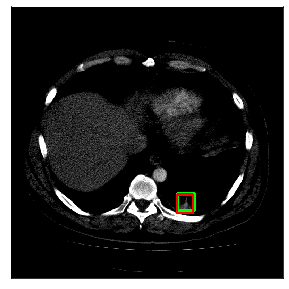

prediction box area:  1023.0471 box area:  1050
0.7297146124485425


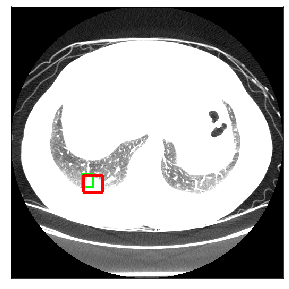

prediction box area:  523.26276 box area:  1116
0.3493725104519409


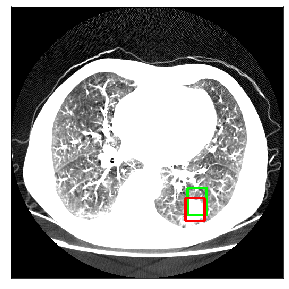

prediction box area:  1795.9131 box area:  1548
0.43716089177715917


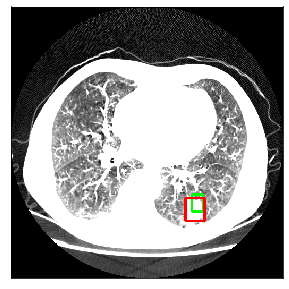

prediction box area:  662.3332 box area:  1548
0.3286798876586294


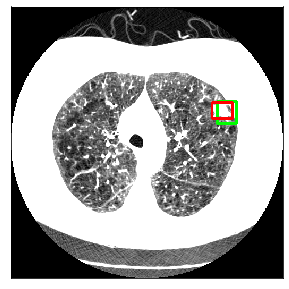

prediction box area:  1483.9928 box area:  1170
0.4783173403824022


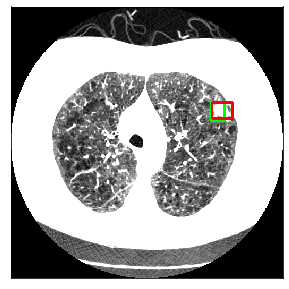

prediction box area:  833.7058 box area:  1170
0.536027569676984


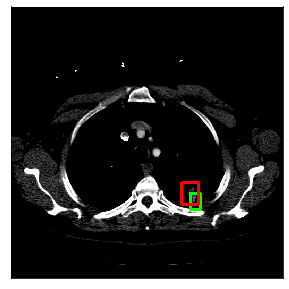

prediction box area:  568.3357 box area:  1271
0.20578915994783967


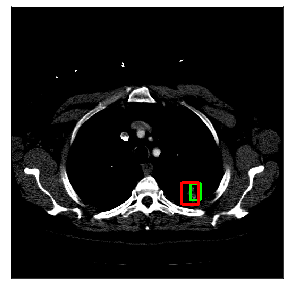

prediction box area:  591.12616 box area:  1271
0.3390092381994696


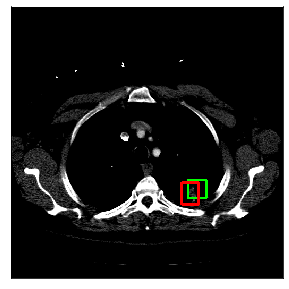

prediction box area:  1128.046 box area:  1271
0.29397270162787253


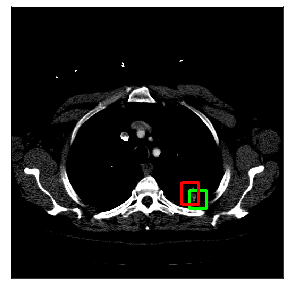

prediction box area:  1091.5477 box area:  1271
0.216993670519486


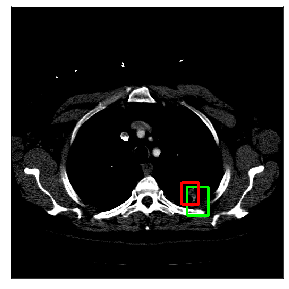

prediction box area:  2214.1697 box area:  1271
0.2512000054134012


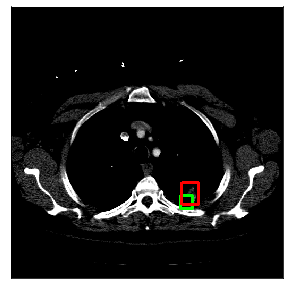

prediction box area:  555.197 box area:  1271
0.23781060323410289


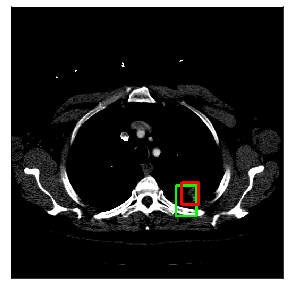

prediction box area:  2230.836 box area:  1271
0.40223422004794673


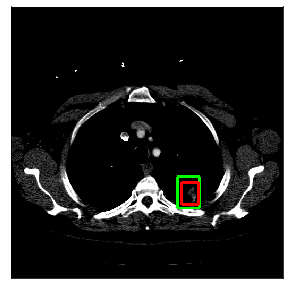

prediction box area:  2386.0479 box area:  1271
0.5405583830649651


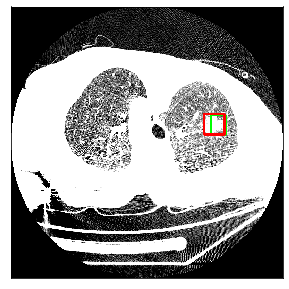

prediction box area:  964.1389 box area:  1444
0.5500581290843982


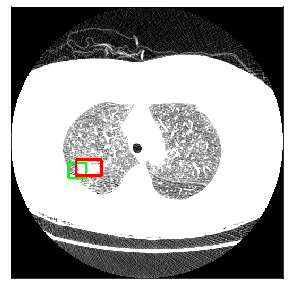

prediction box area:  917.5178 box area:  1440
0.2548703698060927


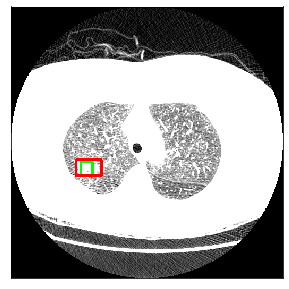

prediction box area:  562.11536 box area:  1440
0.4020435483445652


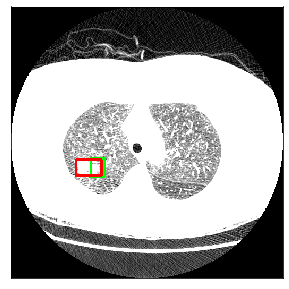

prediction box area:  871.9173 box area:  1440
0.3422014131818628


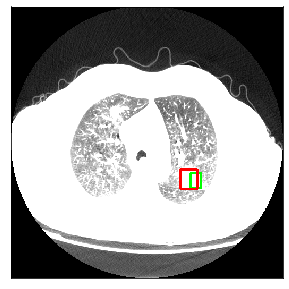

prediction box area:  541.2405 box area:  1147
0.2479615270167161


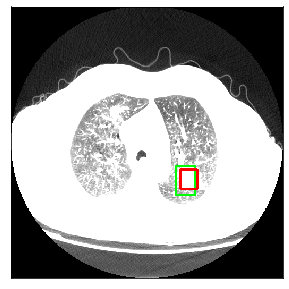

prediction box area:  1953.2163 box area:  1147
0.48572590102609986


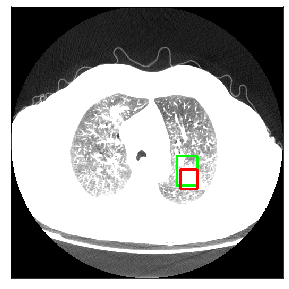

prediction box area:  2112.608 box area:  1147
0.42929800245920147


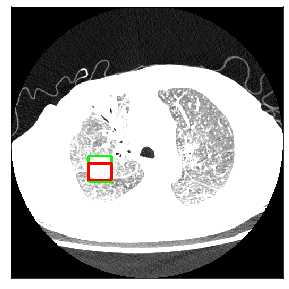

prediction box area:  2067.9375 box area:  1364
0.6317009012319521


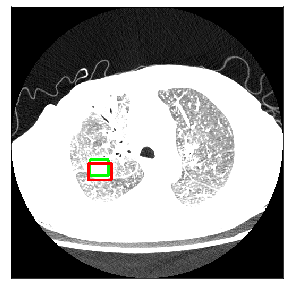

prediction box area:  1032.8722 box area:  1364
0.5119056570260864


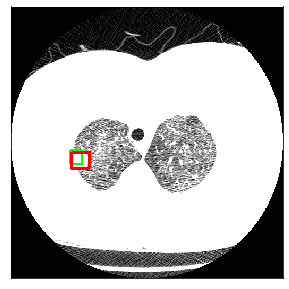

prediction box area:  531.2685 box area:  1023
0.4086314007202628


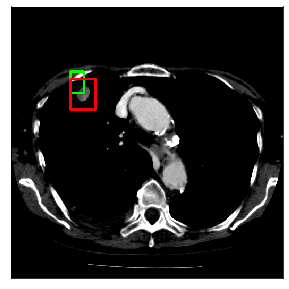

prediction box area:  1022.27136 box area:  2679
0.22633702066142433


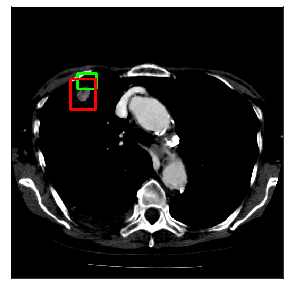

prediction box area:  1017.47864 box area:  2679
0.2199092564213588


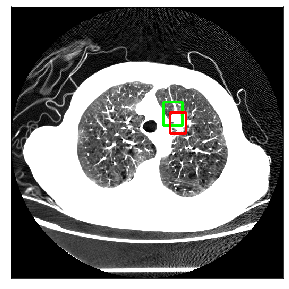

prediction box area:  1594.5818 box area:  1170
0.2982736858161055


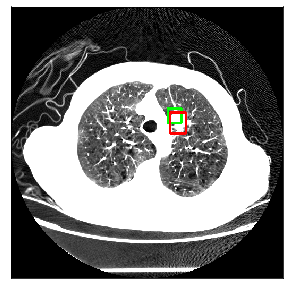

prediction box area:  697.8819 box area:  1170
0.32265751230648965


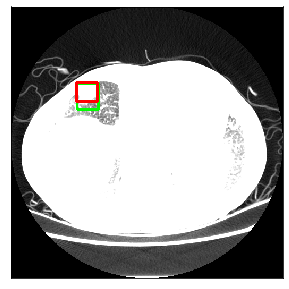

prediction box area:  1961.0428 box area:  1404
0.5958769374688803


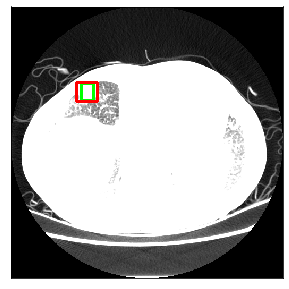

prediction box area:  779.34686 box area:  1404
0.5655781305203139


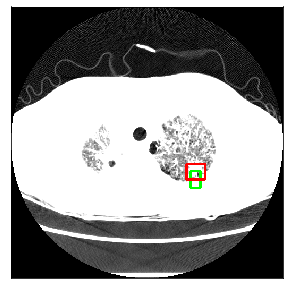

prediction box area:  560.41223 box area:  1015
0.2229682289265449
69 96


In [19]:
count = 0
for index, row in train_data.iterrows():
    path = row.path
    boxes = row.boxes
    boxes = ast.literal_eval(boxes)
    list_box = []
    for i in boxes:
        #xmin #ymax #xmax #ymin
        list_box.append(i[0]) #xmin
        list_box.append(i[1]) #ymin
        list_box.append(i[2]) #xmax
        list_box.append(i[3]) #ymax
        ymin, ymax = int(i[1]),int(i[3]) #ymin ymax        
        xmin, xmax = int(i[0]), int(i[2]) #xmin, xmax

    box, pred_cls = get_prediction(path, 0.0)#threshold very low
    pred_boxes = [[i[0][0], i[0][1], i[1][0], i[1][1]] for i in list(box)] # Bounding boxes

    img = cv2.imread(path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for ind in pred_boxes:
        if (bb_intersection_over_union((list_box),(ind)) > .2):
            count += 1
            img = cv2.imread(path) # Read image with cv2
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
            cv2.rectangle(img, (ind[0], ind[1]),(ind[2], ind[3]),color=(0, 255, 0), thickness=3)
            cv2.rectangle(img, (xmin, ymin),(xmax, ymax),color=(255, 0, 0), thickness=3)
            plt.figure(figsize=(5,5)) # display the output image
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.show()
            print("prediction box area: ", (ind[2] - ind[0]) * (ind[3] - ind[1]), "box area: ", (xmax - xmin) * (ymax - ymin))
            print(bb_intersection_over_union((list_box),(ind) ))

print(count, len(test_data))

In [76]:
test_data

path   imageName  \
0   /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000002.png   
1   /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000121.png   
2   /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000150.png   
3   /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000024.png   
4   /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000048.png   
..                                                ...         ...   
91  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000165.png   
92  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000074.png   
93  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000014.png   
94  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000032.png   
95  /scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...  000097.png   

                                       SOPInstanceUID  \
0   1.3.6.1.4.1.14519.5.2.1.6279.6001.166688876065...   
1   1.3.6.1.4.1.14519.5.2.1.6279.6001.585449803761...   
2   1.3.6.1.4.1.14519.5.2.1.6279.6001.112824881417...   
3   1.3.6.1.4.1.14519.5.2.1.6279.6001.111479005947...   
4   1.3.6.1.4.1.14519.5.2.1.6279.6001.228416880722...   
..                                                ...   
91  1.3.6.1.4.1.14519.5.2.1.6279.6001.208132726260...   
92  1.3.6.1.4.1.14519.5.2.1.6279.6001.286433478734...   
93  1.3.6.1.4.1.14519.5.2.1.6279.6001.274061817261...   
94  1.3.6.1.4.1.14519.5.2.1.6279.6001.572410953751...   
95  1.3.6.1.4.1.14519.5.2.1.6279.6001.171684254800...   

                             boxes   areas  
0    [[80.0, 241.0, 137.0, 266.0]]  1425.0  
1   [[297.0, 303.0, 333.0, 342.0]]  1404.0  
2   [[165.0, 328.0, 199.0, 380.0]]  1768.0  
3    [[83.0, 171.0, 133.0, 207.0]]  1800.0  
4   [[385.0, 327.0, 412.0, 367.0]]  1080.0  
..                             ...     ...  
91  [[387.0, 285.0, 440.0, 320.0]]  1855.0  
92  [[330.0, 297.0, 365.0, 326.0]]  1015.0  
93  [[126.0, 325.0, 161.0, 366.0]]  1435.0  
94  [[104.0, 175.0, 139.0, 212.0]]  1295.0  
95  [[383.0, 318.0, 410.0, 360.0]]  1134.0  

[96 rows x 5 columns]